# Objective:
Predict the time a taxi ride takes



# Data

* Download the data ```wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet```

# Setup

In [25]:
!pip install pyarrow # needed to read parquet data

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import pickle

In [32]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [33]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

## Preprocessing
* Calculate the trip duration (this is the variable we want to predict)
* We will calculate the duration in minutes and use this as our target variable 
    * Use the lambda function to do that. This applies the defined function to every row

In [34]:
# calculate duration in minutes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime 
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [35]:
# use only trip_type=Dispatch
#df = df[df.trip_type==2]
#df.head()

* Visualize the distribution of the target variable 'duration'

/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


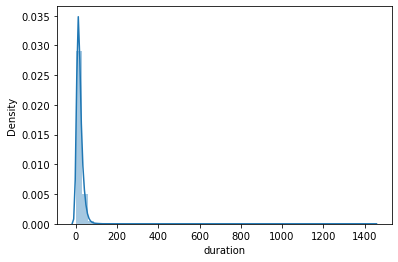

In [36]:
sns.distplot(df.duration);

* We can see that this variable has a very long tail

In [37]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

* We have very long trips, but also very short trips
* We have to do some filtering. For that have a look at some percentiles

In [38]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

* Most of the data is within 1 hour (98% percentile is ~56min)
* From the buisiness point of view it makes sense to focus on this data
* We will filter the data and use only duration times between 1 minute and 1 hour

In [40]:
df = df[(df.duration >= 1) & (df.duration<=60)]

* define categorical and numerical values we will use

In [41]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

* one-hot encode the categorical variables

In [44]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

* We will use DictVectorizer for the one-hot-encoding
* DictVectorizer will treat every variable that is not a numbe as categorical
* We need to change the type of our categorical variables. 
    * Turn the type into string

In [48]:
df[categorical] = df[categorical].astype(str)
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

* Turn the dataframe into a dictionaries

In [50]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [52]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [53]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [55]:
target = 'duration'
y_train = df[target].values

* Instantiate and fit a linear regression model

In [59]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

* We will later use the data for February as validation data
* At the moment we will have a look how the training data is predicted

In [62]:
y_pred = lr.predict(X_train)

/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/frauke/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


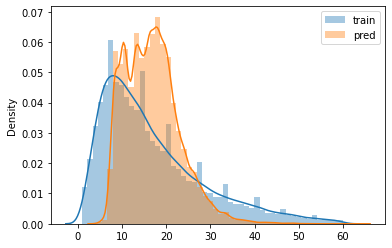

In [65]:
sns.distplot(y_train, label='train')
sns.distplot(y_pred, label='pred')
plt.legend();

In [67]:
mean_squared_error(y_train, y_pred, squared=False)

9.775464208836793

* On average this model is wrong about 9.8 minutes
* Now evaluate the model on the validation data
* Write a function the for preprocessing

In [73]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime 
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration<=60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [76]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [77]:
len(df_train), len(df_val)

(73908, 61921)

In [80]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [86]:
y_train = df_train[target].values
y_val = df_val[target].values

In [87]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.47389023718609

* Try a different model

In [90]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.812725703916977

* The Lasso model is not better in this case
* We can try different models
* We can try different features
    * We can use pick up and drop off location ombined, at the moment they are separate features

In [91]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [92]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [94]:
categorical = ['PU_DO']#['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479513631630414

* This improves the results of the linear regression
* Save this model

In [98]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)